**Project Report**

*Team Members: John DeLeon, Darshan Joshi*

CS 6322-DS1 Image Processing | Spring B 2025

Dr. Choupani | Angelo State University

Department of Computer Science

# Overview

In this project, we explore building a tool that removes the background from an image, isolating the main subject.  Additionally, the user will be allowed to replace the background with one of the following:

* Transparent Background
* Color Background
* Another Image Background

# Environment Setup

## Imports

For our background Removal tool, we used the following python libraries:

* opencv-python
* matplotlib
* numpy

Also, it's worth noting that we are setting default images below for the purposes of the report, but in the tool, the user will be prompted to provide an image.

In [1]:
%%capture
%pip install opencv-python matplotlib numpy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, asksaveasfilename
import cv2
import numpy as np
from matplotlib import pyplot as plt
import logging
import os
from tkinter.colorchooser import askcolor

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Test values for report generation
original_1_image_path = r"./images/test1.jpg"
background_path = r"./images/bg1.jpg"


## Report Helper Methods

We are including a helper function that is used to generate images for the report, but is not necessary for our tool.

In [2]:
def show_image(image, title="Image", is_bgr=True, size=(8, 6),is_transparent=False):
    """
    Displays an image using matplotlib with optional BGR to RGB conversion.
    
    Args:
        image (np.ndarray): Image to show
        title (str): Window title
        is_bgr (bool): Convert BGR to RGB
        size (tuple): Matplotlib figure size
    """
    try:
        fig = plt.figure(figsize=size)
        if is_bgr:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if is_transparent:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
            fig.patch.set_facecolor((0, 0, 0, 0))  # Set figure background to transparent            
            fig.patch.set_alpha(0.0) 
                       
        plt.imshow(image,)
        plt.title(title)
        plt.axis("off")
        plt.show()
    except Exception as e:
        logging.error(f"Error displaying image: {e}")

# Tool Process Flow

## Image Selection

To get the user's filepath input, we use Tkinter's askopenfilename method to prompt the user for an image file and read the file using cv2.imread.

Additionally, if the image is over 800px, we resize the image using cv2.resize to make it manageable for gathering user input and processing.

In [3]:
def get_file_path():
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = askopenfilename(title="Select a file")
    return file_path

def load_image_from_path(file_path, max_dim=800):
    """
    Loads and resizes an image from a given file path.

    Args:
        file_path (str): Path to the image
        max_dim (int): Max dimension (width or height) to resize to.

    Returns:
        tuple: (str path, np.ndarray image or None if error)
    """
    try:
        image = cv2.imread(file_path)
        if image is None:
            raise FileNotFoundError("Could not load image.")
        logging.info(f"Loaded image from: {file_path}")

        h, w = image.shape[:2]
        scale = max_dim / max(h, w)
        if scale < 1:
            image = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
            logging.info(f"Resized image to: {image.shape[1]}x{image.shape[0]}")
        return file_path, image

    except Exception as e:
        logging.error(f"Failed to load image: {e}")
        return None, None
    
def save_file(image, file_path=None):    
    #root = Tk()
    #root.withdraw()  # Hide the root window
    #file_path = asksaveasfilename(defaultextension=".png", filetypes=[("PNG files", "*.png"), ("All files", "*.*")])
    if file_path:
        cv2.imwrite(file_path, image)
        print(f"Image saved to {file_path}")
    else:
        print("Save operation cancelled.")

In our main function, we load the image using the get_file_path() and load_image_from_path functions defined above.

*Note: For report purposes, we have this path predefined and commented out the call to get the user input.*

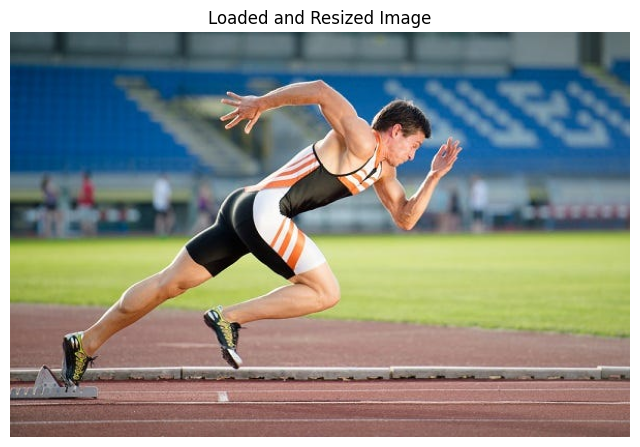

In [4]:
# Test values for report generation defined above
# Uncomment the following line to select a file using a file dialog
#original_1_image_path = get_file_path()
image_path, image = load_image_from_path(original_1_image_path)

if image is not None:
    show_image(image, title="Loaded and Resized Image")
else:
    print("No image loaded.")

## Initial Object Selection

With our Image loaded, we now display the image to get user input to define a bounding box for the main object.  We use cv2 "Mouse as a Paint-Brush" feature to capture mouse events to accomplish this.

In [5]:
def get_user_drawn_rect(image):
    """
    Opens an OpenCV window allowing the user to draw a bounding box.

    Args:
        image (np.ndarray): The input image

    Returns:
        tuple: (x, y, w, h) bounding box
    """
    clone = image.copy()
    rect = []
    drawing = False
    ix, iy = -1, -1

    def draw_rectangle(event, x, y, flags, param):
        nonlocal ix, iy, drawing, rect, clone

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            temp = clone.copy()
            cv2.rectangle(temp, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow("Draw bounding box (Press ENTER to confirm)", temp)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            rect = [min(ix, x), min(iy, y), abs(x - ix), abs(y - iy)]
            cv2.rectangle(clone, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 2)
            cv2.imshow("Draw bounding box (Press ENTER to confirm)", clone)

    # Open window and set callback
    cv2.namedWindow("Draw bounding box (Press ENTER to confirm)")
    cv2.setMouseCallback("Draw bounding box (Press ENTER to confirm)", draw_rectangle)
    cv2.imshow("Draw bounding box (Press ENTER to confirm)", image)

    print("Instructions:")
    print("1. Click and drag to draw a bounding box.")
    print("2. Press ENTER or SPACE to confirm.")
    print("3. Press ESC to cancel.")

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 13 or key == 32:  # ENTER or SPACE
            break
        elif key == 27:  # ESC
            rect = []
            break

    cv2.destroyAllWindows()

    if len(rect) == 4:
        logging.info(f"User-drawn rectangle: {rect}")
        return tuple(rect)
    else:
        logging.warning("Bounding box selection cancelled.")

In [6]:
user_drawn_rectangle = get_user_drawn_rect(image)

Instructions:
1. Click and drag to draw a bounding box.
2. Press ENTER or SPACE to confirm.
3. Press ESC to cancel.


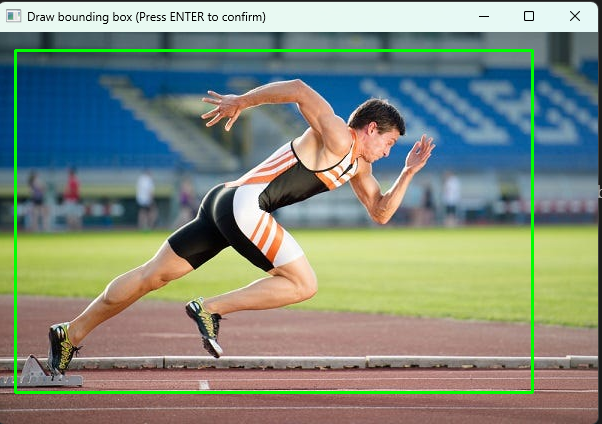

## Initial Image Segmentation

Now that the user has provided the image, as well as the initial bounding box for the object, we apply the following methods to perform an initial segmentation and mask refinement.

* cv2.grabCut - This performs an initial segmentation of the image, classifying each pixel as
  * 0 = Background
  * 1 = Foreground
  * 2 = Probable Background
  * 3 = Probable Foreground
* cv2.morphologyEx (Closed) - This is useful for cleaning up the inside of the foreground object
* cv2.morphologyEx (Open) - Helps remove white noise
* cv2.dilate - Helps to recover lost details such as fingers
* cv2.GaussianBlur - Used to feather the edges

In [7]:
def apply_grabcut(image, rect=None, iter_count=5):
    """
    Applies the GrabCut algorithm to extract the foreground.

    Args:
        image (np.ndarray): Input image (BGR)
        rect (tuple): Bounding box in the format (x, y, w, h)
        iter_count (int): Number of GrabCut iterations

    Returns:
        tuple: (mask, foreground result)
    """
    try:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)  # 0=bg, 1=fg, 2=prob.bg, 3=prob.g
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        if rect is None:
            raise ValueError("Bounding box (rect) is required for GrabCut.")

        # Apply GrabCut with rectangle
        cv2.grabCut(image, mask, rect, bgdModel, fgdModel, iterCount=iter_count, mode=cv2.GC_INIT_WITH_RECT)
        show_image(mask, title="GrabCut Mask", is_bgr=False)        
        # Convert mask to binary: 0 and 2 are background, 1 and 3 are foreground
        output_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        foreground = image * output_mask[:, :, np.newaxis]

        return output_mask * 255, foreground, mask

    except Exception as e:
        logging.error(f"GrabCut failed: {e}")
        return None, None

def refine_mask(mask, kernel_size=7, blur_size=7, iterations=7):
    """
    Cleans and smooths a binary mask.

    Args:
        mask (np.ndarray): Binary mask (0 or 255)
        kernel_size (int): Size of morphological kernel
        blur_size (int): Size of Gaussian blur kernel
        iterations (int): Dilation iterations

    Returns:
        np.ndarray: Refined mask
    """
    try:
        # Convert to 0/1 mask if needed
        binary_mask = (mask > 0).astype(np.uint8)

        # Morph kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        # Fill small holes and remove noise
        closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

        # Optional dilation to recover lost details (e.g. fingers, wires)
        dilated = cv2.dilate(opened, kernel, iterations=iterations)

        # Feather the edges
        blurred = cv2.GaussianBlur(dilated.astype(np.float32), (blur_size, blur_size), 0)
        mask2 = np.zeros_like(blurred)

        # Scale to [0, 255] and return
        refined = (blurred * 255).astype(np.uint8)
        show_image(refined, title="Refined Mask", is_bgr=False)
        return refined

    except Exception as e:
        logging.error(f"Mask refinement failed: {e}")
        return mask

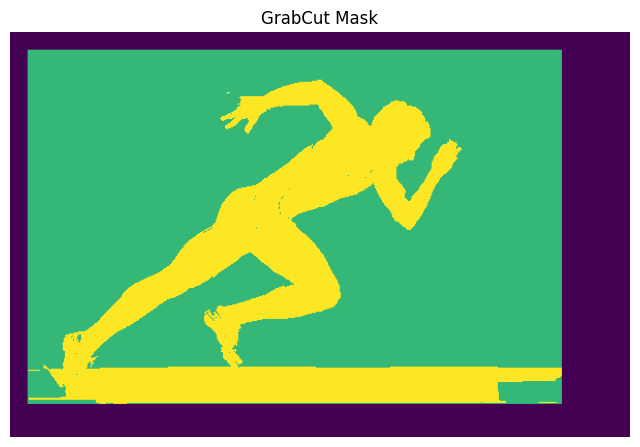

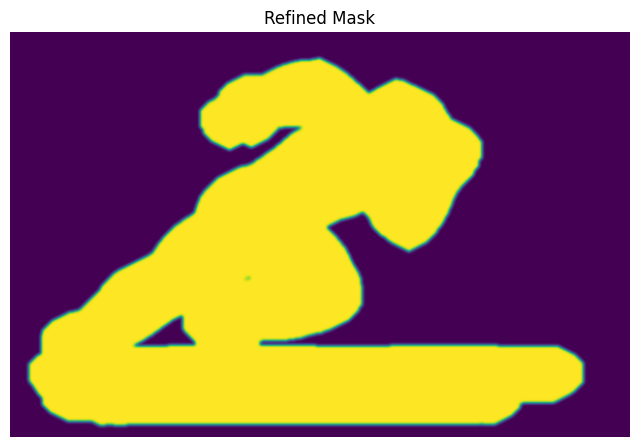

In [8]:
if user_drawn_rectangle:
    mask, foreground, mask_init = apply_grabcut(image, user_drawn_rectangle)
    if mask is not None:
        refined_mask = refine_mask(mask)
        final_result = cv2.bitwise_and(image, image, mask=(refined_mask // 255))

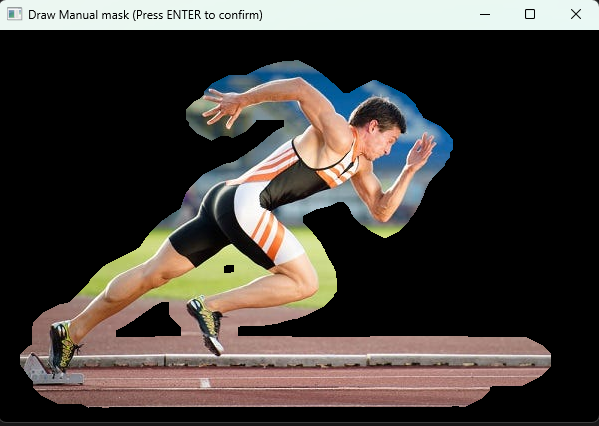

The grabCut method did a good job at getting an inital starting point for segmenting the foreground and background, but it currently includes some parts of the background.

## Mask Refinement With User Input

We've now applied our initial segmentation to the image, although you can see that there are still various elements of the background that is being included in the foreground.  To get a better representation of what should be included in the foreground and background, we provide the user with the opportunity to define where there is definitely background using the left-click and drag functionality or definitely foreground using the right-click and drag functionality.  We allow the user to iterate over updating the final mask and continue to the next step once there are no longer any alterations to the mask once the user hits Enter or Spacebar.

Similar to how we drew the bounding box, we visualize the user input using the "Mouse as a Paint-Brush" feature and cv2.line function.

In [9]:
def get_user_manual_mask(image):
    """
    Opens an OpenCV window allowing the user to draw a bounding box.

    Args:
        image (np.ndarray): The input image

    Returns:
        np.ndarray: Binary mask
    """
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clone = image.copy()
        
    drawing = False
    ix, iy = -1, -1
    val = 255
    mask = np.ones_like(gray, dtype=np.uint8)
    has_drawn = False
    print("Instructions:")
    print("1. Left-Click and drag to draw lines to mark background areas.")
    print("                      OR                                       ")
    print("   Right-Click and drag to draw lines to mark foreground areas.")
    print("2. Press ENTER or SPACE to confirm.")
    print("3. Press ESC to cancel.")

    def draw_manual_mask(event, x, y, flags, param):
        nonlocal ix, iy, drawing, has_drawn, mask, clone, val
    
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            has_drawn = True
            val = 0
            ix, iy = x, y
        elif event == cv2.EVENT_RBUTTONDOWN:
            drawing = True
            has_drawn = True
            val = 255
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            temp = clone.copy()            
            cv2.line(mask, (ix, iy), (x, y), val, 2)
            cv2.line(clone, (ix, iy), (x, y), (0, val, 0), 2)
            cv2.imshow("Draw Manual mask (Press ENTER to confirm)", temp)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False 
        
        elif event == cv2.EVENT_RBUTTONUP:
            drawing = False            

    # Open window and set callback
    cv2.namedWindow("Draw Manual mask (Press ENTER to confirm)")
    cv2.setMouseCallback("Draw Manual mask (Press ENTER to confirm)", draw_manual_mask)
    cv2.imshow("Draw Manual mask (Press ENTER to confirm)", image) 

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 13 or key == 32:  # ENTER or SPACE
            break
        elif key == 27:  # ESC
            mask = []
            break
            
    cv2.destroyAllWindows()

    return mask, has_drawn

Instructions:
1. Left-Click and drag to draw lines to mark background areas.
                      OR                                       
   Right-Click and drag to draw lines to mark foreground areas.
2. Press ENTER or SPACE to confirm.
3. Press ESC to cancel.


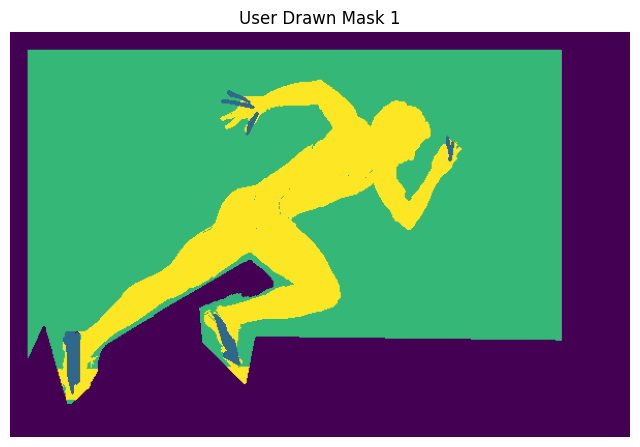

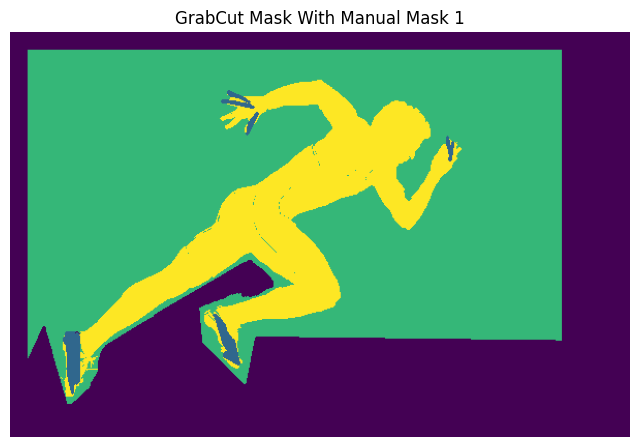

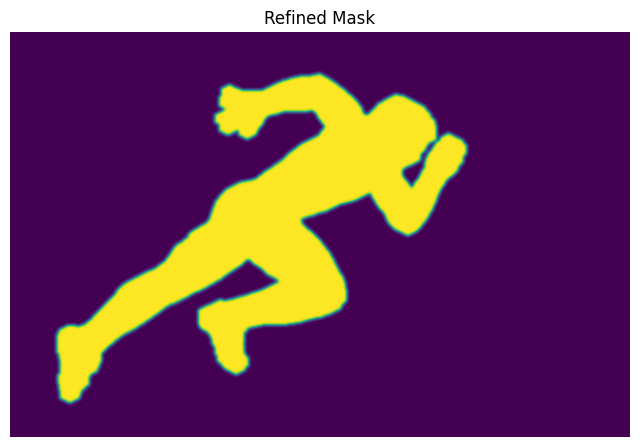

Instructions:
1. Left-Click and drag to draw lines to mark background areas.
                      OR                                       
   Right-Click and drag to draw lines to mark foreground areas.
2. Press ENTER or SPACE to confirm.
3. Press ESC to cancel.
No mask drawn. Exiting.


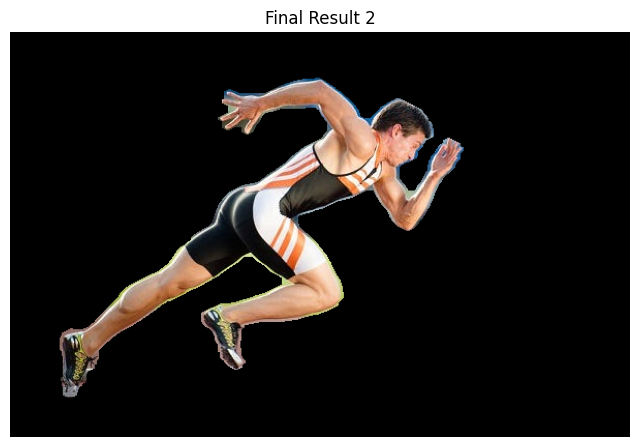

In [10]:
manual_update_count = 1
while True:
    user_drawn_mask, has_drawn = get_user_manual_mask(final_result)
    if not has_drawn:
        print("No mask drawn. Exiting.")
        break
    else:
        mask_init[user_drawn_mask == 0] = 0
        mask_init[user_drawn_mask == 255] = 1
        show_image(mask_init, title=f"User Drawn Mask {manual_update_count}", is_bgr=False)        
        bgdModel = np.zeros((1,65), dtype=np.float64)
        fgdModel = np.zeros((1,65), dtype=np.float64)
        mask, bgdModel, fgdModel = cv2.grabCut(image,mask_init,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

        show_image(mask, title=f"GrabCut Mask With Manual Mask {manual_update_count}", is_bgr=False)
        manual_update_count += 1

        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        mask2 = mask2 * 255
        refined_mask = refine_mask(mask2, kernel_size=5, blur_size=7, iterations=3)
            # Apply refined mask
        final_result = cv2.bitwise_and(image, image, mask=(refined_mask // 255))        
show_image(final_result, title=f"Final Result {manual_update_count}", is_bgr=True)

### Screenshots of the segmentation Progress in UI:

This is the initial segmentation created by applying our bounding box in the GrabCut method.

![initial_foreground_selection.png](./screenshots/initial_foreground_selection.png)

Screen with User Mask Input applied.  Black area is background (both user defined and initially defined) while the green areas indicates user defined foreground.

![User_applied_mask.png](./screenshots/User_applied_mask.png)

The final segmentation created by merging user Mask Input with the initial GrabCut mask.

![Final_foreground_Mask_applied.png](./screenshots/Final_foreground_Mask_applied.png)

## User Selects Background Replacement Options

User picks which background replacement they would like to perform

```python
print("Select an option:")
print("1. Transparent background.")
print("2. Color background.")
print("3. Image background.")
option = -1
while option not in [1, 2, 3]:
    try:
        option = int(input("Enter your choice (1/2/3): "))
    except ValueError:
        print("Invalid input. Please enter 1, 2, or 3.")
if option == 1:
    final_result = apply_transparency(image, refined_mask)
elif option == 2:
    selected_color = askcolor(title="Choose a color")[0]
    print(f"Selected color: {selected_color}")
    final_result = replace_with_solid_color(image, refined_mask, color=selected_color)  # Example: Red background
elif option == 3:
    bg_image = get_file_path()
    if bg_image:
        background_image = cv2.imread(bg_image)
        if background_image is None:
            print("Error loading background image.")
            return
        final_result = replace_background_with_image(image, refined_mask, background_image)
    else:
        print("No background image selected.")
        return

```

# Background Replacements

## Transparent Background

To apply transparency to the background, we add an alpha channel to the image using cv2.cvtColor with the cv2.COLOR_BGR2BGRA option.  We then set our mask to the alpha channel, which will make the background transparent, and the foreground fully visible.

In [11]:
def apply_transparency(image, mask):
    """
    Applies mask to image and returns a 4-channel BGRA image (transparent background).

    Args:
        image (np.ndarray): Input BGR image
        mask (np.ndarray): Refined mask, values in [0, 255]

    Returns:
        np.ndarray: Image with alpha channel (BGRA)
    """
    try:
        h, w, channels = image.shape
        if channels < 4:
            transparent = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
        else:
            transparent = image.copy()        
        transparent[:,:, 3] = mask
        return transparent
    except Exception as e:
        logging.error(f"Failed to apply transparency: {e}")
        return None
    
final_result = apply_transparency(image, refined_mask)
save_file(final_result, file_path='./output/transparent_image.png')

Image saved to ./output/transparent_image.png


### Transparent Background Image Output File
![transparent_image.png](./output/transparent_image.png)

## Color Background

To allow the user to provide a color input, we use the tkinter askcolor dialog.  For the report, we default the selected color to green.

To apply the color to the background, we create a background matrix with the color, and convert our mask to a 3-channel binary mask.  From there, we apply the mask to the image and apply the inverse of the mask to the background matrix making the background color active in only where the foreground was 0.  

From there we merge the two together to get the final result.

In [12]:
def replace_with_solid_color(image, mask, color=(255, 255, 255)):
    """
    Replaces the background of the image with a solid BGR color.

    Args:
        image (np.ndarray): Input image
        mask (np.ndarray): Refined mask (0-255)
        color (tuple): BGR color tuple (e.g., white=(255,255,255))

    Returns:
        np.ndarray: Image with solid background
    """
    try:
        background = np.full_like(image, color, dtype=np.uint8)
        mask_3ch = cv2.merge([mask // 255] * 3)  # Convert to 3-channel binary mask
        result = (image * mask_3ch) + (background * (1 - mask_3ch))
        return result
    except Exception as e:
        logging.error(f"Solid color replacement failed: {e}")
        return None

Selected color: (0, 255, 0)


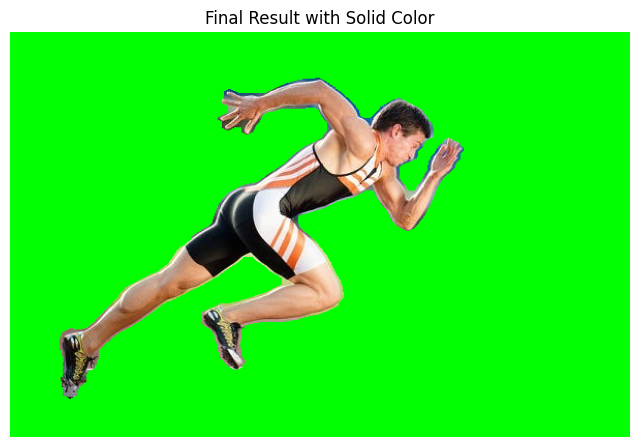

Image saved to ./output/solid_color_image.png


In [13]:
# Test values for report generation
selected_color = (0, 255, 0)  # Default color (green)
# Uncomment the following line to select a file using a file dialog
#selected_color = askcolor(title="Choose a color")[0]
print(f"Selected color: {selected_color}")
final_result = replace_with_solid_color(image, refined_mask, color=selected_color)
show_image(final_result, title="Final Result with Solid Color", is_bgr=True)
save_file(final_result, file_path='./output/solid_color_image.png')

## Image Background

For the background, we first resize the background image to be the same shape as our original image.  

Just like the color background, we convert our mask to a 3-channel binary mask. From there, we apply the mask to the image and apply the inverse of the mask to the background matrix making the background image active in only where the foreground was 0.  

From there we merge the two together to get the final result.

In [14]:
def replace_background_with_image(image, mask, background_image):
    """
    Replaces background of the subject with a new image.

    Args:
        image (np.ndarray): Original image (BGR)
        mask (np.ndarray): Refined mask (0-255)
        background_image (np.ndarray): New background (must match dimensions)

    Returns:
        np.ndarray: Composite image
    """
    try:
        # Resize background to match input
        background_resized = cv2.resize(background_image, (image.shape[1], image.shape[0]))
        mask_3ch = cv2.merge([mask // 255] * 3)

        # Composite
        result = (image * mask_3ch) + (background_resized * (1 - mask_3ch))
        return result
    except Exception as e:
        logging.error(f"Background replacement failed: {e}")
        return None

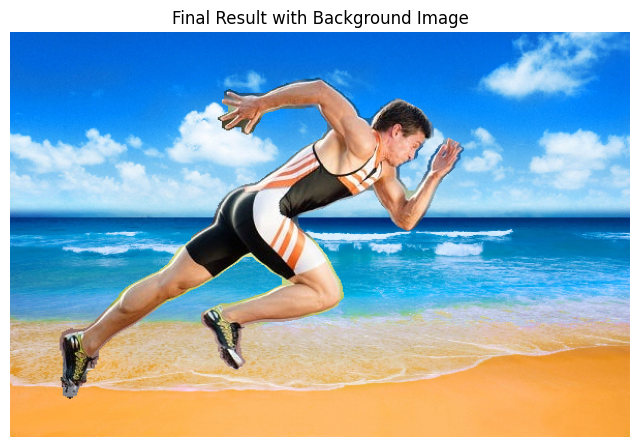

Image saved to ./output/background_image.png


In [15]:
# Test values for report generation
# Uncomment the following line to select a file using a file dialog
#background_path = get_file_path()
background_image = cv2.imread(background_path)
if background_image is None:
    print("Error loading background image.")
else:
    final_result = replace_background_with_image(image, refined_mask, background_image)
    show_image(final_result, title="Final Result with Background Image", is_bgr=True)
    save_file(final_result, file_path='./output/background_image.png')

# Alternative Method: Thresholding for High-Contrast Images

This method works well if:

The background is very bright or very dark compared to the subject

The subject has clearly defined edges

### Thresholding Likely Won’t Work Well because Thresholding assumes:

The background is uniform or high-contrast

The subject and background can be separated by brightness alone

Your image has:

Multiple background elements (dirt, shrubs, city, mountains)

Gradients and depth of field (blurry background)

Likely similar brightness between clothes/road and surroundings

So this method may produce a broken mask, especially around the edges and small details like arms or hair.

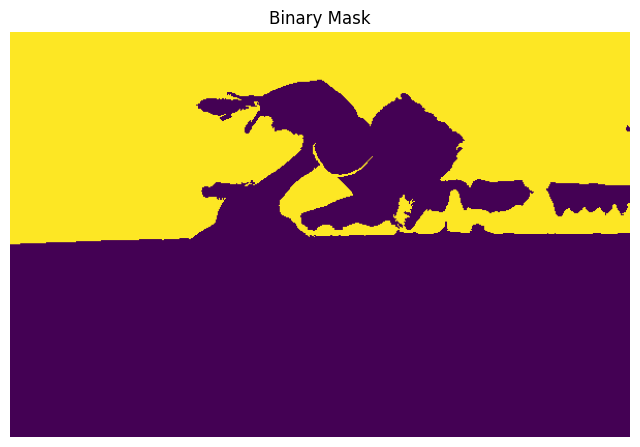

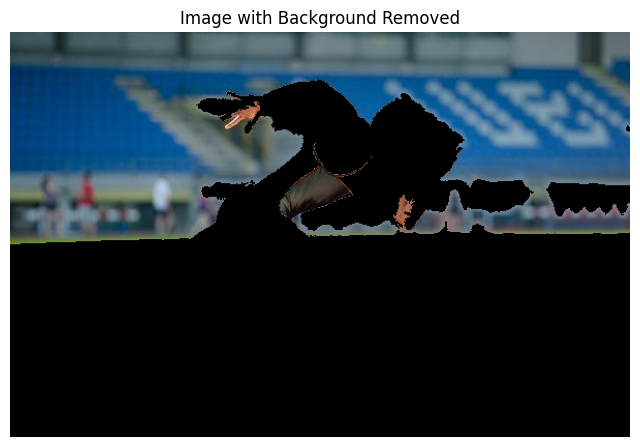

In [16]:
def create_mask_by_thresholding(image, threshold_value=127):
    """
    Performs basic background removal using grayscale thresholding.

    Args:
        image (np.ndarray): Input BGR image
        threshold_value (int): Threshold value to separate background

    Returns:
        tuple: (mask, result) where mask is binary mask and result is masked image
    """
    try:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply binary thresholding
        _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find all external contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            raise ValueError("No contours found")

        # Get the largest contour
        main_contour = max(contours, key=cv2.contourArea)

        # Create an empty mask
        mask = np.zeros_like(gray)

        # Draw filled contour on mask
        cv2.drawContours(mask, [main_contour], -1, 255, thickness=cv2.FILLED)

        # Apply the mask to the original image
        result = cv2.bitwise_and(image, image, mask=mask)

        return mask, result

    except Exception as e:
        logging.error(f"Thresholding mask generation failed: {e}")
        return None, None

# Run this after loading the image
mask, result = create_mask_by_thresholding(image)

if mask is not None:
    show_image(mask, title="Binary Mask", is_bgr=False)
    show_image(result, title="Image with Background Removed")
else:
    print("Thresholding failed.")



# Conclusion

We found that using Thresholding would not be useful for most user provided images, although it could be useful in specific cases.  

We received great results when using a user provided bounding box, the GrabCut method, in addition to a user defined update to the mask generated by GrabCut.  The main drawback to this method is that it does require quite a bit of user input and would not be appropriate if our goal was complete automation.

Areas for future exploration could be using deep learning to reduce the amount of user input required.

# References

* https://docs.opencv.org/4.11.0/d9/d61/tutorial_py_morphological_ops.html
* https://docs.opencv.org/4.11.0/d8/d83/tutorial_py_grabcut.html
* https://docs.opencv.org/4.11.0/db/d5b/tutorial_py_mouse_handling.html
